**เรียนรู้วิธีการจัดประเภทรูปภาพโดยใช้การถ่ายทอดการเรียนรู้ (Transfer learning) จากเครือข่ายที่ได้รับการฝึกฝนมาก่อน (Pre-trained model)**

แบบจำลองที่ผ่านการฝึกอบรมมาแล้ว คือ เครือข่ายที่ได้รับการฝึกอบรมก่อนหน้านี้ด้วยชุดข้อมูลขนาดใหญ่โดยทั่วไปจะใช้กับงานการจัดประเภทรูปภาพขนาดใหญ่ เรานำเครือข่ายนี้มาปรับแต่งให้เหมาะกับงานของเราได้

ถ้าแบบจำลองได้รับการฝึกฝนบนชุดข้อมูลที่มีขนาดใหญ่และมีคุณลักษณะทั่วไปเพียงพอ แบบจำลองนี้จะใช้เป็นแบบจำลองทั่วไปของภาพอื่น ๆ ได้อย่างมีประสิทธิภาพ

เราสามารถใช้ประโยชน์จากคุณลักษณะที่เรียนรู้เหล่านี้ได้โดยไม่ต้องเริ่มต้นใหม่ตั้งแต่ต้น

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 1. นำเข้า TensorFlow และไลบรารีอื่น ๆ (Import TensorFlow and other libraries)

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from tensorflow.keras.preprocessing import image_dataset_from_directory

from sklearn.metrics import classification_report

# 2. เตรียมข้อมูลรูปภาพ
ดาวน์โหลดชุดข้อมูลเกี่ยวกับภาพขยะประมาณ 200 ภาพ ชุดข้อมูลประกอบด้วย 4 ไดเรกทอรีย่อยหนึ่งรายการต่อคลาส:
```
garbage_dataset_vu/
  BlueGarbage/
  GreenGarbage/
  RedGarbage/
  YellowGarbage/
```



In [5]:
!unzip -q /content/drive/MyDrive/dataset_SUT/garbage_dataset_vu.zip #chage 1

# 3. โหลดชุดข้อมูลรูปภาพโดยใช้ keras.preprocessing

โหลดภาพเหล่านี้จากดิสก์โดยใช้ยูทิลิตี้ [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory)  หากต้องการโหลดข้อมูลของคุณเองตั้งแต่เริ่มต้นคุณสามารถเขียนโค้ดโดยไปที่บทแนะนำการ [โหลดรูปภาพ](https://www.tensorflow.org/tutorials/load_data/images)

## 3.1 สร้างชุดข้อมูล

กำหนดพารามิเตอร์สำหรับตัวโหลด:

ใช้ภาพ 80% สำหรับการฝึกฝน (Training dataset) และ 20% สำหรับการตรวจสอบความถูกต้อง (Validation dataset)

In [6]:
import pathlib
data_dir = pathlib.Path('/content/garbage_dataset_vu') #change 2

BATCH_SIZE = 32
IMG_SIZE = (224, 224) # change 3 depend on your input model

train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=IMG_SIZE,
  batch_size=BATCH_SIZE)

Found 200 files belonging to 4 classes.
Using 160 files for training.
Found 200 files belonging to 4 classes.
Using 40 files for validation.


แสดงรายชื่อคลาสที่ใช้ในการจำแนก

In [7]:
class_names = train_dataset.class_names
print(class_names)

['BlueGarbage', 'GreenGarbage', 'RedGarbage', 'YellowGarbage']


## 3.2 แสดงข้อมูลรูปภาพ
แสดงข้อมูลรูปภาพจำนวน 25 ภาพแรกจากชุดข้อมูลการฝึกฝน (Training dataset)

In [ ]:
plt.figure(figsize=(14, 14))
for images, labels in train_dataset.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

เนื่องจากชุดข้อมูลดั้งเดิมไม่มีชุดทดสอบคุณจึงต้องสร้างขึ้นมา ในการทำเช่นนั้นให้กำหนดจำนวนข้อมูลที่มีอยู่ในชุดการตรวจสอบความถูกต้องโดยใช้ tf.data.experimental.cardinality จากนั้นย้าย 20% ของข้อมูลเหล่านี้ไปยังชุดทดสอบ

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 2)
validation_dataset = validation_dataset.skip(val_batches // 2)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 1
Number of test batches: 1


## 3.3 Configure the dataset for performance 
กำหนดค่าชุดข้อมูลเพื่อประสิทธิภาพ ใช้การดึงข้อมูลล่วงหน้าแบบบัฟเฟอร์เพื่อให้คุณสามารถเรียกใช้ข้อมูลจากดิสก์ได้วิธีนี้จะช่วยให้มั่นใจได้ว่าชุดข้อมูลจะไม่กลายเป็นคอขวดขณะฝึกโมเดลของคุณหากชุดข้อมูลของคุณมีขนาดใหญ่เกินกว่าที่จะใส่ลงในหน่วยความจำได้

In [ ]:
# problem ฃ
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

## 3.4 Standardize the data

ใช้การเพิ่มข้อมูล
เมื่อคุณไม่มีชุดข้อมูลรูปภาพขนาดใหญ่เป็นแนวทางปฏิบัติที่ดีในการนำเสนอความหลากหลายของกลุ่มตัวอย่าง คุณสามารถใช้การเปลี่ยนแปลงแบบสุ่ม เช่น การหมุนและการพลิกแนวนอน สิ่งนี้ช่วยให้โมเดลเรียนรู้ข้อมูลการฝึกในแง่มุมต่าง ๆ และลด การเกิด Overfitting มากเกินไป 

In [ ]:
# หมุนภาพ
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

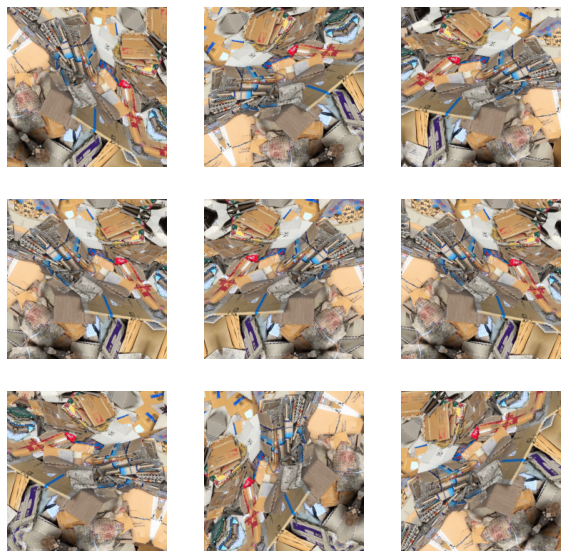

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

ข้อมูลค่าสี RGB อยู่ในช่วง [0, 255] ไม่เหมาะสำหรับโครงข่ายประสาทเทียม โดยทั่วไปคุณควรพยายามทำให้ค่าอินพุตของคุณมีขนาดเล็ก ที่นี่คุณจะกำหนดค่ามาตรฐานให้อยู่ในช่วง [0, 1] โดยใช้ Rescaling layer

In [ ]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./255, offset= -1)

#4. สร้างแบบจำลองใหม่จากแบบจำลองที่ผ่านการฝึกมาแล้ว
ตัวอย่าง การสร้างโมเดลพื้นฐานจากโมเดล MobileNet V2 ที่ พัฒนาโดย Google ซึ่งได้รับการฝึกมามาแล้วล่วงหน้าด้วยชุดข้อมูล ImageNet ซึ่งเป็นชุดข้อมูลขนาดใหญ่ที่ประกอบด้วยรูปภาพ 1.4 ล้านภาพ ใน 1,000 คลาส

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
# https://www.tensorflow.org/api_docs/python/tf/keras/applications?hl=th
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE, # change 4
                                               include_top=False,
                                               weights='imagenet')

9412608/9406464 [==============================] - 0s 0us/step


ตัวสกัดคุณลักษณะ MobileNetV2 นี้จะแปลงรูปภาพ 224x224x3 แต่ละภาพเป็นบล็อกขนาด 7x7x1280 

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 7, 7, 1280)


การแยกคุณลักษณะ
ในขั้นตอนนี้เราจะตรึงฐาน Convolutional ที่สร้างขึ้นจากขั้นตอนก่อนหน้าและใช้เป็นตัวแยกคุณสมบัติ นอกจากนี้เรายังเพิ่มเลเยอร์ที่ด้านบนและฝึกฝนในระดับบนสุด

ตรึงฐาน Convolutional
เป็นสิ่งสำคัญที่จะต้องตรึงฐาน Convolutional ก่อนที่คุณจะรวบรวมและฝึกโมเดล โดยการตั้งค่า layer.trainable = False ป้องกันไม่ให้มีการอัปเดตน้ำหนักในเลเยอร์ที่กำหนดระหว่างการฝึกแบบจำลอง MobileNet V2 ที่มีหลายเลเยอร์

In [ ]:
# default
base_model.trainable = False

In [ ]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

ใช้เลเยอร์ tf.keras.layers.GlobalAveragePooling2D เพื่อแปลงคุณสมบัติเป็นเวกเตอร์ขนาด 1280 ต่อภาพ

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


Layer สุดท้าย คือ จำนวนคลาสที่ใช้ในการจำแนก

In [ ]:
prediction_layer = tf.keras.layers.Dense(4) # Dense(4) is classifier กี่ class 
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 4)


In [ ]:
#input
inputs = tf.keras.Input(shape=(224, 224, 3)) #change 5 depend on your model that you use 

x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x) #Dropout(0.2) = Dropout 20%

#output
outputs = prediction_layer(x)

#model
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

พารามิเตอร์ 2.25M ใน MobileNet ถูกแช่แข็ง แต่มี 5.1K พารามิเตอร์ในชั้น fully connected layers จำนวน 2 ชั้น สุดท้ายที่เปลี่ยนแปลงค่า weight และ bias

In [ ]:
len(model.trainable_variables)

2

ฝึกโมเดล

In [ ]:
initial_epochs = 10

history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

#if val_accuracy > accuracy = Overfitting

Epoch 1/10
5/5 [==============================] - 11s 685ms/step - loss: 1.6878 - accuracy: 0.3168 - val_loss: 1.8397 - val_accuracy: 0.3750
Epoch 2/10
5/5 [==============================] - 8s 440ms/step - loss: 1.5045 - accuracy: 0.3266 - val_loss: 1.3970 - val_accuracy: 0.5000
Epoch 3/10
5/5 [==============================] - 8s 443ms/step - loss: 1.4031 - accuracy: 0.3758 - val_loss: 1.0823 - val_accuracy: 0.6250
Epoch 4/10
5/5 [==============================] - 8s 440ms/step - loss: 1.3820 - accuracy: 0.3701 - val_loss: 0.9998 - val_accuracy: 0.5000
Epoch 5/10
5/5 [==============================] - 8s 437ms/step - loss: 1.1774 - accuracy: 0.5260 - val_loss: 1.2406 - val_accuracy: 0.3750
Epoch 6/10
5/5 [==============================] - 8s 435ms/step - loss: 1.3433 - accuracy: 0.3966 - val_loss: 1.1204 - val_accuracy: 0.3750
Epoch 7/10
5/5 [==============================] - 8s 437ms/step - loss: 1.3313 - accuracy: 0.3855 - val_loss: 0.6692 - val_accuracy: 0.8750
Epoch 8/10
5/5 [===

มาดูกราฟการเรียนรู้ของการฝึกและการตรวจสอบความถูกต้อง /กราฟ การสูญเสีย เมื่อใช้โมเดลพื้นฐาน MobileNet V2 เป็นตัวสกัดคุณลักษณะแบบคงที่ (ไม่มีการปรับค่าน่ำหนักในชั้น Conv ในขณะฝึก)

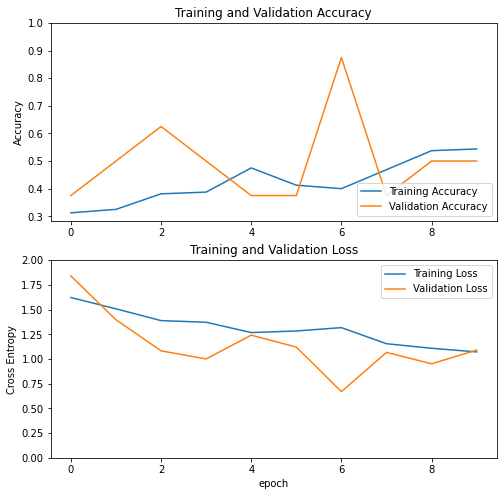

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,2.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()
#Training and Validation Accuracy: เส้นสีส้ม must under the blue line

ในการทดสอบการสกัดคุณลักษณะเราได้ฝึกเพียงไม่กี่ชั้นบนโมเดลพื้นฐาน MobileNet V2 น้ำหนักของเครือข่ายก่อนการฝึกอบรม ไม่ได้ รับการปรับปรุงในระหว่างการฝึกอบรม

วิธีหนึ่งในการเพิ่มประสิทธิภาพให้ดียิ่งขึ้นไปอีกคือการฝึก (หรือ "fine-tuning") น้ำหนักของชั้นบนสุดของแบบจำลองที่ผ่านการฝึกอบรมแล้วควบคู่ไปกับการฝึกที่เราเพิ่มเข้าไป ขั้นตอนการฝึกอบรมจะบังคับให้ปรับน้ำหนักบนแผนที่คุณลักษณะทั่วไปไปจนถึงคุณลักษณะที่เกี่ยวข้องกับชุดข้อมูลโดยเฉพาะ

In [ ]:
base_model.trainable = True

# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 224, 224, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 224, 224, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1280)              0     

In [ ]:
len(model.trainable_variables)

56

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/20
5/5 [==============================] - 11s 606ms/step - loss: 1.0361 - accuracy: 0.5547 - val_loss: 0.9634 - val_accuracy: 0.6250
Epoch 11/20
5/5 [==============================] - 8s 455ms/step - loss: 0.7856 - accuracy: 0.6796 - val_loss: 0.6636 - val_accuracy: 0.8750
Epoch 12/20
5/5 [==============================] - 8s 457ms/step - loss: 0.5437 - accuracy: 0.8168 - val_loss: 0.5633 - val_accuracy: 0.8750
Epoch 13/20
5/5 [==============================] - 8s 461ms/step - loss: 0.4405 - accuracy: 0.8922 - val_loss: 0.5555 - val_accuracy: 0.8750
Epoch 14/20
5/5 [==============================] - 8s 457ms/step - loss: 0.3449 - accuracy: 0.9278 - val_loss: 0.4143 - val_accuracy: 0.8750
Epoch 15/20
5/5 [==============================] - 8s 451ms/step - loss: 0.3922 - accuracy: 0.8408 - val_loss: 0.2049 - val_accuracy: 1.0000
Epoch 16/20
5/5 [==============================] - 8s 461ms/step - loss: 0.2575 - accuracy: 0.9328 - val_loss: 0.1287 - val_accuracy: 1.0000
Epoch 17/20


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

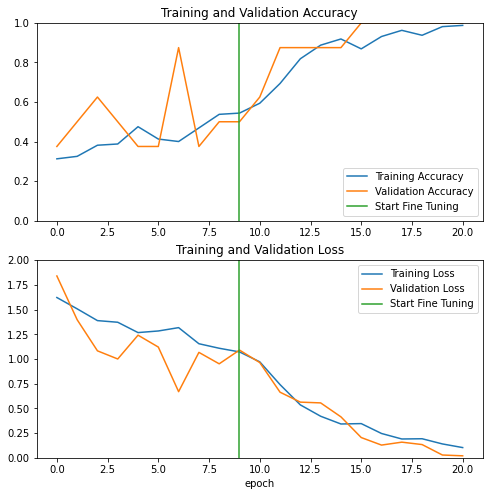

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 2.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(test_dataset) # *test_dataset only
#loss, accuracy = model.evaluate(validation_dataset)

print('Test accuracy :', accuracy)

1/1 [==============================] - 2s 2s/step - loss: 0.0773 - accuracy: 1.0000
Test accuracy : 1.0


In [ ]:
model_name = 'keras_pretrained_garbage_model.h5'
model_path = os.path.join('/content/drive/MyDrive/dataset_SUT/Garbage_h5_pretrain_model/', model_name)
model.save(model_path)
print('Saved trained model at %s ' % model_path)


NameError: ignored

In [ ]:
garbage_url = "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcQssRzVt2FwpJ2QHCwKi8TOs12aSCA8lAHN8A&usqp=CAU"
garbage_path = tf.keras.utils.get_file('garbage_dataset_vu', origin=garbage_url)

img = tf.keras.preprocessing.image.load_img(
    garbage_path, target_size=IMG_SIZE
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

plt.imshow(img)


NameError: ignored

RedGarbage with a 35.54% confidence.


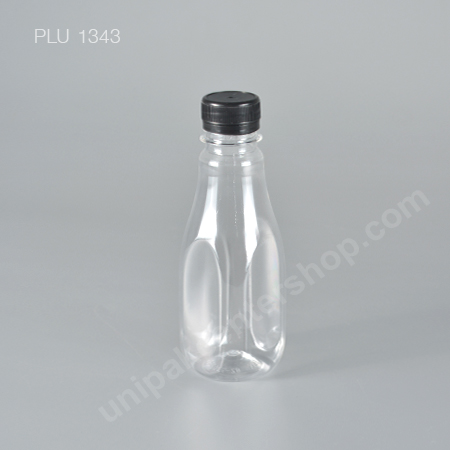

In [12]:
# to make predictions
import numpy as np
import os
import tensorflow as tf
from keras.preprocessing import image
#path_img = '/content/garbage_dataset_vu/RedGarbage/pam(17).jpg'
path_img = '/content/drive/MyDrive/test_model/1343M1.jpg'
test_image = image.load_img(path_img, target_size = (224, 224)) # ขนาดต้องเท่ากับตัว model 

test_image = image.img_to_array(test_image)
test_image = np.expand_dims(test_image, axis = 0)

# load Model
from keras.models import load_model

model_name = 'keras_pretrained_garbage_model.h5'
model_path = os.path.join('/content/drive/MyDrive/dataset_SUT/Garbage_h5_pretrain_model/', model_name)
model = load_model(model_path)

result = model.predict(test_image)
score = tf.nn.softmax(result[0])
print("{} with a {:.2f}% confidence.".format(class_names[np.argmax(score)], 100 * np.max(score)))

from IPython.display import Image
Image(path_img)